MULTI UAV 

In [1]:
class MultiUAVEnv:
    def __init__(self, num_uavs=2):
        self.num_uavs = num_uavs
        self.positions = [[0, 0] for _ in range(num_uavs)]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.positions = [[0, 0] for _ in range(self.num_uavs)]
        states = []
        for position in self.positions:
            states.extend(self._get_state_for_position(position))
        return states

    def _get_state_for_position(self, position):
        dx = self.goal[0] - position[0]
        dy = self.goal[1] - position[1]
        return [position[0], position[1], dx, dy]

    def step(self, actions):
        rewards = []
        dones = []
        next_states = []
        
        for i, action in enumerate(actions):
            # Update position
            new_position = [self.positions[i][0] + self.actions[action][0], self.positions[i][1] + self.actions[action][1]]

            # Check if out of grid
            if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
                rewards.append(-5)
                dones.append(False)
            else:
                self.positions[i] = new_position
                # Check if goal is reached
                if self.positions[i] == self.goal:
                    rewards.append(10)
                    dones.append(True)
                else:
                    rewards.append(-0.1)
                    dones.append(False)

            next_states.extend(self._get_state_for_position(self.positions[i]))

        return next_states, rewards, dones

# Testing the environment
multi_uav_env = MultiUAVEnv(num_uavs=2)
state = multi_uav_env.reset()
print(f"Initial state: {state}")
next_states, rewards, dones = multi_uav_env.step([0, 2])  # Moving the first UAV up and the second UAV down
print(f"Next states: {next_states}, Rewards: {rewards}, Dones: {dones}")


Initial state: [0, 0, 3, 3, 0, 0, 3, 3]
Next states: [0, 1, 3, 2, 0, 0, 3, 3], Rewards: [-0.1, -5], Dones: [False, False]


MULTI UAV DQN 

In [1]:
import torch
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Multi UAV Environment
class MultiUAVEnvV2:
    def __init__(self, num_uavs=5):
        self.num_uavs = num_uavs
        self.positions = [[0, 0] for _ in range(num_uavs)]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.positions = [[0, 0] for _ in range(self.num_uavs)]
        states = []
        for pos in self.positions:
            states.extend(self.get_state_from_position(pos))
        return states

    def get_state_from_position(self, position):
        dx = self.goal[0] - position[0]
        dy = self.goal[1] - position[1]
        return [position[0], position[1], dx, dy]

    def step(self, actions):
        next_states = []
        rewards = []
        dones = []

        for idx, action in enumerate(actions):
            new_position = [self.positions[idx][0] + self.actions[action][0], self.positions[idx][1] + self.actions[action][1]]

            if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
                next_states.extend(self.get_state_from_position(self.positions[idx]))
                rewards.append(-5)
                dones.append(False)
            else:
                self.positions[idx] = new_position
                if self.positions[idx] == self.goal:
                    next_states.extend(self.get_state_from_position(self.positions[idx]))
                    rewards.append(10)
                    dones.append(True)
                else:
                    next_states.extend(self.get_state_from_position(self.positions[idx]))
                    rewards.append(-0.1)
                    dones.append(False)

        return next_states, rewards, dones

# DQN Model for Multi UAVs
class MultiUAVDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(MultiUAVDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_actions * 5)  # Output Q-values for each action for each UAV
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Training function for multi UAVs
def train_multi_uav_dqn_with_replay(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                                   epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = [False] * 5
        step_count = 0
        total_reward = 0

        while not all(done) and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = model(state_tensor)
            actions = []
            
            for i in range(5):  # For each UAV
                if random.uniform(0, 1) < epsilon:
                    actions.append(random.choice(range(num_actions)))
                else:
                    start_idx = i * num_actions
                    end_idx = start_idx + num_actions
                    actions.append(torch.argmax(q_values[start_idx:end_idx]).item())

            next_state, rewards, done = env.step(actions)
            total_reward += sum(rewards)
            memory.push((state, actions, rewards, next_state, done))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q_list = []
                target_q_list = []
                for i in range(5):
                    current_q_list.append(model(batch_state).narrow(1, i * num_actions, num_actions).gather(1, batch_action[:, i].unsqueeze(1)).squeeze(1))
                    next_q = model(batch_next_state).narrow(1, i * num_actions, num_actions).max(1)[0]
                    target_q_list.append(batch_reward[:, i] + gamma * next_q * (~batch_done[:, i]))

                current_qs = torch.stack(current_q_list).transpose(0, 1)
                target_qs = torch.stack(target_q_list).transpose(0, 1)
                loss = criterion(current_qs, target_qs.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return episode_rewards

# Main Execution
memory = ReplayMemory(capacity=2000)
env_v5 = MultiUAVEnvV2(num_uavs=5)
model_v5 = MultiUAVDQN(input_dim=20, num_actions=4)
rewards_v5 = train_multi_uav_dqn_with_replay(env_v5, model_v5, memory, episodes=50, lr=0.001, max_steps=100)


Episode 1/50, Total Reward: -650.8999999999996, Epsilon: 0.99
Episode 2/50, Total Reward: -505.7999999999998, Epsilon: 0.99
Episode 3/50, Total Reward: -502.1000000000001, Epsilon: 0.99
Episode 4/50, Total Reward: -739.6999999999992, Epsilon: 0.98
Episode 5/50, Total Reward: -631.2999999999995, Epsilon: 0.98
Episode 6/50, Total Reward: -655.7999999999989, Epsilon: 0.97
Episode 7/50, Total Reward: -609.8999999999994, Epsilon: 0.97
Episode 8/50, Total Reward: -664.3999999999994, Epsilon: 0.96
Episode 9/50, Total Reward: -505.1999999999995, Epsilon: 0.96
Episode 10/50, Total Reward: -604.9999999999998, Epsilon: 0.95
Episode 11/50, Total Reward: -535.7999999999996, Epsilon: 0.95
Episode 12/50, Total Reward: -540.0999999999998, Epsilon: 0.94
Episode 13/50, Total Reward: -561.7999999999994, Epsilon: 0.94
Episode 14/50, Total Reward: -634.6999999999996, Epsilon: 0.93
Episode 15/50, Total Reward: -734.7999999999992, Epsilon: 0.93
Episode 16/50, Total Reward: -532.6999999999997, Epsilon: 0.92
E

MULTI UAV 

In [9]:
import torch
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Multi UAV Environment
class MultiUAVEnvV2:
    def __init__(self, num_uavs=5):
        self.num_uavs = num_uavs
        self.positions = [[0, 0] for _ in range(num_uavs)]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4  # Size of the grid

    def reset(self):
        self.positions = [[0, 0] for _ in range(self.num_uavs)]
        states = []
        for pos in self.positions:
            states.extend(self.get_state_from_position(pos))
        return states

    def get_state_from_position(self, position):
        dx = self.goal[0] - position[0]
        dy = self.goal[1] - position[1]
        return [position[0], position[1], dx, dy]

    def step(self, actions):
        next_states = []
        rewards = []
        dones = []

        for i in range(self.num_uavs):
            new_position = [self.positions[i][0] + self.actions[actions[i]][0], 
                            self.positions[i][1] + self.actions[actions[i]][1]]

            # Check if out of grid
            if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(-1)
                dones.append(False)
                continue

            self.positions[i] = new_position

            # Check if goal is reached
            if self.positions[i] == self.goal:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(10)
                dones.append(True)
            else:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(-0.1)
                dones.append(False)

        return next_states, rewards, dones

# Multi UAV DQN Model
class MultiUAVDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(MultiUAVDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_actions * 5)  # We have 5 UAVs and each has `num_actions` actions

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Training function with Experience Replay for Multi UAVs
def train_multi_uav_dqn_with_replay(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                                   epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    all_episode_rewards = []
    individual_episode_rewards = [[] for _ in range(env.num_uavs)]

    for episode in range(episodes):
        state = env.reset()
        done = [False] * env.num_uavs
        step_count = 0
        total_reward = 0
        individual_rewards = [0] * env.num_uavs

        while not all(done) and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                actions = [random.choice(range(num_actions)) for _ in range(env.num_uavs)]
            else:
                q_values = model(state_tensor)
                actions = [torch.argmax(q_values[i:i+num_actions]).item() for i in range(0, len(q_values), num_actions)]

            next_state, rewards, done = env.step(actions)
            total_reward += sum(rewards)

            for i in range(env.num_uavs):
                individual_rewards[i] += rewards[i]
                memory.push((state, actions[i], rewards[i], next_state, done[i]))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        all_episode_rewards.append(total_reward)
        for i in range(env.num_uavs):
            individual_episode_rewards[i].append(individual_rewards[i])
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    return all_episode_rewards, individual_episode_rewards

# Main Execution
memory = ReplayMemory(capacity=2000)
env_v5 = MultiUAVEnvV2(num_uavs=5)
model_v5 = MultiUAVDQN(input_dim=20, num_actions=4)
all_rewards_v5, individual_rewards_v5 = train_multi_uav_dqn_with_replay(env_v5, model_v5,memory,episodes=100,lr=0.001,max_steps=100)


Episode 1/100, Total Reward: -77.90000000000008, Epsilon: 0.99
Episode 2/100, Total Reward: -6.299999999999956, Epsilon: 0.99
Episode 3/100, Total Reward: -126.10000000000008, Epsilon: 0.99
Episode 4/100, Total Reward: -88.7, Epsilon: 0.98
Episode 5/100, Total Reward: -42.599999999999895, Epsilon: 0.98
Episode 6/100, Total Reward: -65.49999999999993, Epsilon: 0.97
Episode 7/100, Total Reward: 93.4, Epsilon: 0.97
Episode 8/100, Total Reward: -2.499999999999969, Epsilon: 0.96
Episode 9/100, Total Reward: 29.40000000000004, Epsilon: 0.96
Episode 10/100, Total Reward: -40.89999999999996, Epsilon: 0.95
Episode 11/100, Total Reward: 11.200000000000028, Epsilon: 0.95
Episode 12/100, Total Reward: 26.50000000000005, Epsilon: 0.94
Episode 13/100, Total Reward: 28.500000000000085, Epsilon: 0.94
Episode 14/100, Total Reward: -0.2000000000000166, Epsilon: 0.93
Episode 15/100, Total Reward: 18.400000000000013, Epsilon: 0.93
Episode 16/100, Total Reward: -7.3999999999999355, Epsilon: 0.92
Episode 17

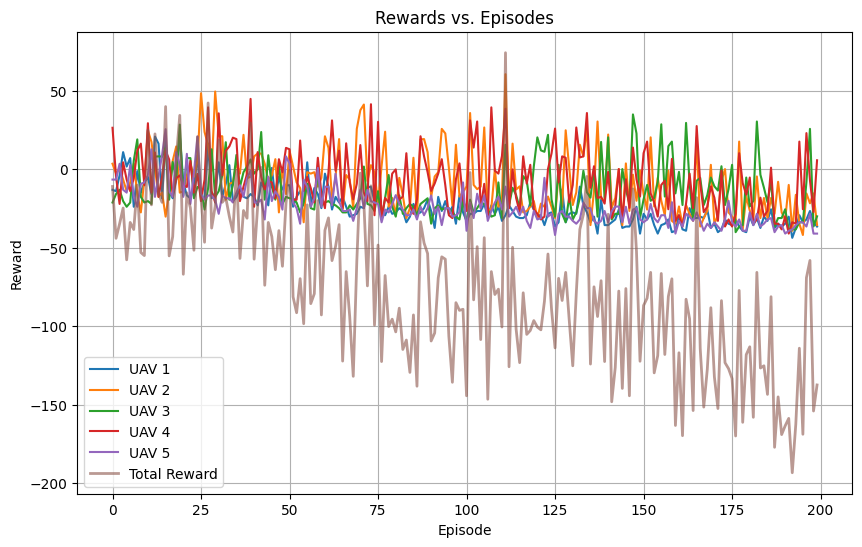

Average Reward over 200 episodes: -76.03


In [11]:
import torch
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Multi UAV Environment
class MultiUAVEnvV2:
    def __init__(self, num_uavs=5):
        self.num_uavs = num_uavs
        self.positions = [[0, 0] for _ in range(num_uavs)]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4

    def reset(self):
        self.positions = [[0, 0] for _ in range(self.num_uavs)]
        states = []
        for pos in self.positions:
            states.extend(self.get_state_from_position(pos))
        return states

    def get_state_from_position(self, position):
        dx = self.goal[0] - position[0]
        dy = self.goal[1] - position[1]
        return [position[0], position[1], dx, dy]

    def step(self, actions):
        next_states = []
        rewards = []
        dones = []

        for i in range(self.num_uavs):
            new_position = [self.positions[i][0] + self.actions[actions[i]][0], 
                            self.positions[i][1] + self.actions[actions[i]][1]]

            if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(-1)
                dones.append(False)
                continue

            self.positions[i] = new_position

            if self.positions[i] == self.goal:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(10)
                dones.append(True)
            else:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(-0.1)
                dones.append(False)

        return next_states, rewards, dones

# DQN Model for Multi UAVs
class MultiUAVDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(MultiUAVDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_actions * 5)  # 5 UAVs

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Training function with Experience Replay for Multi UAVs
def train_multi_uav_dqn_with_replay(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                                   epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    all_episode_rewards = []
    individual_episode_rewards = [[] for _ in range(env.num_uavs)]

    for episode in range(episodes):
        state = env.reset()
        done = [False] * env.num_uavs
        step_count = 0
        total_reward = 0
        individual_rewards = [0] * env.num_uavs

        while not all(done) and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                actions = [random.choice(range(num_actions)) for _ in range(env.num_uavs)]
            else:
                q_values = model(state_tensor)
                actions = [torch.argmax(q_values[i:i+num_actions]).item() for i in range(0, len(q_values), num_actions)]

            next_state, rewards, done = env.step(actions)
            total_reward += sum(rewards)

            for i in range(env.num_uavs):
                individual_rewards[i] += rewards[i]
                memory.push((state, actions[i], rewards[i], next_state, done[i]))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        all_episode_rewards.append(total_reward)
        for i in range(env.num_uavs):
            individual_episode_rewards[i].append(individual_rewards[i])

    return all_episode_rewards, individual_episode_rewards

# Visualization function
def plot_rewards(all_rewards, individual_rewards):
    plt.figure(figsize=(10,6))
    for i, rewards in enumerate(individual_rewards):
        plt.plot(rewards, label=f'UAV {i + 1}')
    plt.plot(all_rewards, label='Total Reward', linewidth=2, alpha=0.6)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.title('Rewards vs. Episodes')
    plt.show()

# Main Execution
memory = ReplayMemory(capacity=2000)
env_v5 = MultiUAVEnvV2(num_uavs=5)
model_v5 = MultiUAVDQN(input_dim=20, num_actions=4)
all_rewards_v5, individual_rewards_v5 = train_multi_uav_dqn_with_replay(env_v5, model_v5, memory, episodes=200)

# Visualization
plot_rewards(all_rewards_v5, individual_rewards_v5)
average_reward = sum(all_rewards_v5) / len(all_rewards_v5)
print(f"Average Reward over {len(all_rewards_v5)} episodes: {average_reward:.2f}")



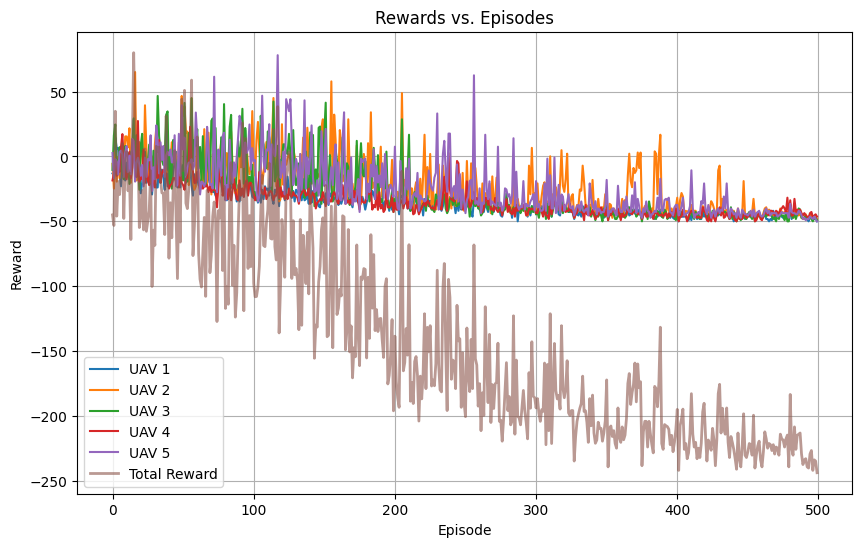

Average Reward over 500 episodes: -142.76


In [13]:
import torch
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Multi UAV Environment
class MultiUAVEnvV2:
    def __init__(self, num_uavs=5):
        self.num_uavs = num_uavs
        self.positions = [[0, 0] for _ in range(num_uavs)]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4

    def reset(self):
        self.positions = [[0, 0] for _ in range(self.num_uavs)]
        states = []
        for pos in self.positions:
            states.extend(self.get_state_from_position(pos))
        return states

    def get_state_from_position(self, position):
        dx = self.goal[0] - position[0]
        dy = self.goal[1] - position[1]
        return [position[0], position[1], dx, dy]

    def step(self, actions):
        next_states = []
        rewards = []
        dones = []

        for i in range(self.num_uavs):
            new_position = [self.positions[i][0] + self.actions[actions[i]][0], 
                            self.positions[i][1] + self.actions[actions[i]][1]]

            if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(-1)
                dones.append(False)
                continue

            self.positions[i] = new_position

            if self.positions[i] == self.goal:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(10)
                dones.append(True)
            else:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(-0.1)
                dones.append(False)

        return next_states, rewards, dones

# DQN Model for Multi UAVs
class MultiUAVDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(MultiUAVDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_actions * 5)  # 5 UAVs

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Training function with Experience Replay for Multi UAVs
def train_multi_uav_dqn_with_replay(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                                   epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    all_episode_rewards = []
    individual_episode_rewards = [[] for _ in range(env.num_uavs)]

    for episode in range(episodes):
        state = env.reset()
        done = [False] * env.num_uavs
        step_count = 0
        total_reward = 0
        individual_rewards = [0] * env.num_uavs

        while not all(done) and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                actions = [random.choice(range(num_actions)) for _ in range(env.num_uavs)]
            else:
                q_values = model(state_tensor)
                actions = [torch.argmax(q_values[i:i+num_actions]).item() for i in range(0, len(q_values), num_actions)]

            next_state, rewards, done = env.step(actions)
            total_reward += sum(rewards)

            for i in range(env.num_uavs):
                individual_rewards[i] += rewards[i]
                memory.push((state, actions[i], rewards[i], next_state, done[i]))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        all_episode_rewards.append(total_reward)
        for i in range(env.num_uavs):
            individual_episode_rewards[i].append(individual_rewards[i])

    return all_episode_rewards, individual_episode_rewards

# Visualization function
def plot_rewards(all_rewards, individual_rewards):
    plt.figure(figsize=(10,6))
    for i, rewards in enumerate(individual_rewards):
        plt.plot(rewards, label=f'UAV {i + 1}')
    plt.plot(all_rewards, label='Total Reward', linewidth=2, alpha=0.6)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.title('Rewards vs. Episodes')
    plt.show()

# Main Execution
memory = ReplayMemory(capacity=2000)
env_v5 = MultiUAVEnvV2(num_uavs=5)
model_v5 = MultiUAVDQN(input_dim=20, num_actions=4)
all_rewards_v5, individual_rewards_v5 = train_multi_uav_dqn_with_replay(env_v5, model_v5, memory, episodes=500)

# Visualization
plot_rewards(all_rewards_v5, individual_rewards_v5)
average_reward = sum(all_rewards_v5) / len(all_rewards_v5)
print(f"Average Reward over {len(all_rewards_v5)} episodes: {average_reward:.2f}")



MULTI UAV (episode=10000)

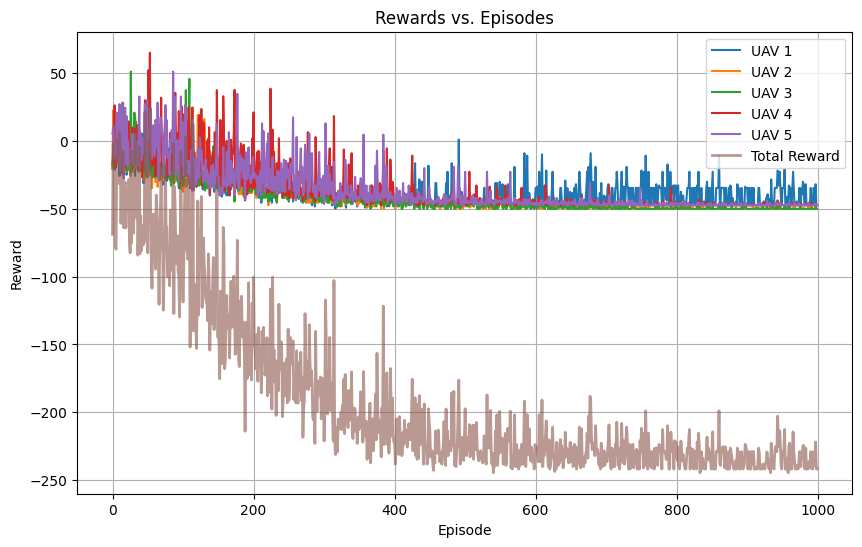

Average Reward over 1000 episodes: -191.37


In [14]:
import torch
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Multi UAV Environment
class MultiUAVEnvV2:
    def __init__(self, num_uavs=5):
        self.num_uavs = num_uavs
        self.positions = [[0, 0] for _ in range(num_uavs)]
        self.goal = [3, 3]
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Up, Right, Down, Left
        self.grid_size = 4

    def reset(self):
        self.positions = [[0, 0] for _ in range(self.num_uavs)]
        states = []
        for pos in self.positions:
            states.extend(self.get_state_from_position(pos))
        return states

    def get_state_from_position(self, position):
        dx = self.goal[0] - position[0]
        dy = self.goal[1] - position[1]
        return [position[0], position[1], dx, dy]

    def step(self, actions):
        next_states = []
        rewards = []
        dones = []

        for i in range(self.num_uavs):
            new_position = [self.positions[i][0] + self.actions[actions[i]][0], 
                            self.positions[i][1] + self.actions[actions[i]][1]]

            if new_position[0] < 0 or new_position[0] >= self.grid_size or new_position[1] < 0 or new_position[1] >= self.grid_size:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(-1)
                dones.append(False)
                continue

            self.positions[i] = new_position

            if self.positions[i] == self.goal:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(10)
                dones.append(True)
            else:
                next_states.extend(self.get_state_from_position(self.positions[i]))
                rewards.append(-0.1)
                dones.append(False)

        return next_states, rewards, dones

# DQN Model for Multi UAVs
class MultiUAVDQN(nn.Module):
    def __init__(self, input_dim, num_actions):
        super(MultiUAVDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_actions * 5)  # 5 UAVs

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Training function with Experience Replay for Multi UAVs
def train_multi_uav_dqn_with_replay(env, model, memory, episodes=100, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, 
                                   epsilon_decay=0.995, lr=0.01, max_steps=50, batch_size=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    num_actions = 4
    epsilon = epsilon_start
    all_episode_rewards = []
    individual_episode_rewards = [[] for _ in range(env.num_uavs)]

    for episode in range(episodes):
        state = env.reset()
        done = [False] * env.num_uavs
        step_count = 0
        total_reward = 0
        individual_rewards = [0] * env.num_uavs

        while not all(done) and step_count < max_steps:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            
            if random.uniform(0, 1) < epsilon:
                actions = [random.choice(range(num_actions)) for _ in range(env.num_uavs)]
            else:
                q_values = model(state_tensor)
                actions = [torch.argmax(q_values[i:i+num_actions]).item() for i in range(0, len(q_values), num_actions)]

            next_state, rewards, done = env.step(actions)
            total_reward += sum(rewards)

            for i in range(env.num_uavs):
                individual_rewards[i] += rewards[i]
                memory.push((state, actions[i], rewards[i], next_state, done[i]))

            if len(memory) > batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32)
                batch_action = torch.tensor(batch_action, dtype=torch.long)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32)
                batch_done = torch.tensor(batch_done, dtype=torch.bool)

                current_q = model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
                next_q = model(batch_next_state).max(1)[0]
                target_q = batch_reward + gamma * next_q * (~batch_done)

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            state = next_state
            step_count += 1

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        all_episode_rewards.append(total_reward)
        for i in range(env.num_uavs):
            individual_episode_rewards[i].append(individual_rewards[i])

    return all_episode_rewards, individual_episode_rewards

# Visualization function
def plot_rewards(all_rewards, individual_rewards):
    plt.figure(figsize=(10,6))
    for i, rewards in enumerate(individual_rewards):
        plt.plot(rewards, label=f'UAV {i + 1}')
    plt.plot(all_rewards, label='Total Reward', linewidth=2, alpha=0.6)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.title('Rewards vs. Episodes')
    plt.show()

# Main Execution
memory = ReplayMemory(capacity=2000)
env_v5 = MultiUAVEnvV2(num_uavs=5)
model_v5 = MultiUAVDQN(input_dim=20, num_actions=4)
all_rewards_v5, individual_rewards_v5 = train_multi_uav_dqn_with_replay(env_v5, model_v5, memory, episodes=1000)

# Visualization
plot_rewards(all_rewards_v5, individual_rewards_v5)
average_reward = sum(all_rewards_v5) / len(all_rewards_v5)
print(f"Average Reward over {len(all_rewards_v5)} episodes: {average_reward:.2f}")

